# 1. SETTINGS

In [167]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import spearmanr
import lightgbm as lgb
import random

In [168]:
# garbage collection
import gc
gc.enable()

In [169]:
# warnings
import warnings
warnings.filterwarnings("ignore")

In [170]:
# pandas options
pd.set_option("display.max_columns", None)

# 2. IMPORT

In [171]:
# data name (used for saving files too)
data_name = "data_v4_0_60_under"

In [172]:
# import datasets
data = pd.read_csv("../data/prepared/" + str(data_name) + ".csv", compression = "gzip")

In [173]:
# data name (used for saving files too)
data_name = "data_v4_0_60_under_wlp_lm_bm_f34_reg"

In [174]:
# drop high recency from train
#data = data[(data.Week == 121) | (data.Recency2 < 27)]
data = data[(data.Week == 121) | (data.Recency1 < data.Recency1.max())]
data.shape

(2668912, 45)

# 3. PREPARATIONS

### ADD MORE FEATURES

In [175]:
# compute BuySell dummy
data["Buy"] = 0
data["Buy"][data.BuySell == "Buy"] = 1
print(data.shape)

(2668912, 45)


In [176]:
### RF Ratios

#data["R12_ratio"] = data.Recency1 / data.Recency2
#data["R13_ratio"] = data.Recency1 / data.Recency3
#data["R14_ratio"] = data.Recency1 / data.Recency4
#data["R56_ratio"] = data.Recency5 / data.Recency6

#data["F12_ratio"] = data.Frequency1 / data.Frequency2
#data["F13_ratio"] = data.Frequency1 / data.Frequency3
#data["F14_ratio"] = data.Frequency1 / data.Frequency4
#data["F56_ratio"] = data.Frequency5 / data.Frequency6

data["F34_ratio_exceeds_05"] = data.Frequency3 / data.Frequency4
data["F34_ratio_exceeds_05"][data["F34_ratio_exceeds_05"] <  0.5] = 0
data["F34_ratio_exceeds_05"][data["F34_ratio_exceeds_05"] >= 0.5] = 1

#data.shape

In [177]:
# add last week sum (CUST)
tmp = data.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["CustomerIdx", "Week", "LastWeekCustSum"]
tmp["Week"] = tmp.Week + 1
data = data.merge(tmp, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

# add last week sum (BOND)
tmp = data.sort_values(by = ["Week"], ascending = True).groupby(["IsinIdx", "Week"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["IsinIdx", "Week", "LastWeekBondSum"]
tmp["Week"] = tmp.Week + 1
data = data.merge(tmp, how = "left", on = ["IsinIdx", "Week"])
print(data.shape)

(2668912, 47)
(2668912, 48)


In [178]:
### ADD PRICE AND NOTIONAL

tmp = pd.read_csv("../data/prepared/price_notional.csv", compression = "gzip")

# add last week price sum (CUST)
tmp2 = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp2 = tmp2.Price.sum().reset_index()
tmp2.columns = ["CustomerIdx", "Week", "LastWeekCustPriceSum"]
tmp2["Week"] = tmp2.Week + 1
data = data.merge(tmp2, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

# add last week notional sum (CUST)
tmp2 = tmp.sort_values(by = ["Week"], ascending = True).groupby(["CustomerIdx", "Week"], as_index = True)
tmp2 = tmp2.NotionalEUR.sum().reset_index()
tmp2.columns = ["CustomerIdx", "Week", "LastWeekCustNotionalSum"]
tmp2["Week"] = tmp2.Week + 1
data = data.merge(tmp2, how = "left", on = ["CustomerIdx", "Week"])
print(data.shape)

(2668912, 49)
(2668912, 50)


In [179]:
### ADD CUSTOMER INDICATORS

#cust  = pd.read_csv("../data/raw/Customer.csv")
#cust.head()

# create dummies for customers
#cust_dummies = pd.concat([cust.CustomerIdx, pd.get_dummies(cust.Subsector)], axis = 1)

# merge customer dummies
#data = data.merge(cust_dummies, on = "CustomerIdx", how = "left")
#print(data.shape)

In [180]:
### ADD BOND FEATURES [V1]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat1_AK")

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", "t", "timeOnMarket", "percentoflifeleft"]], how = "left", on = "IsinIdx")
#print(data.shape)

In [181]:
### ADD NEW BOND FEATURES [V2]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat2_AK")

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", 'ymeansq', 'ymeancube', 'zmeansq', 'zmeancube',
#                             'years_tomaturity', 'count', 'ratingspread', 'ratingZspread']], 
#                  how = "left", on = "IsinIdx")
#print(data.shape)

In [182]:
### ADD BOND FEATURES [V3]

# load bond data
#bond_stat = pd.read_csv("../data/prepared/bondstat3_AK")
#bond_stat.head()

# merge bond data
#data = data.merge(bond_stat[["IsinIdx", 'predyield', 'predprice']], how = "left", on = "IsinIdx")
#print(data.shape)

In [183]:
### BOND-SPECIFIC FINANCIAL INDICATORS

#bond  = pd.read_csv("../data/raw/Isin.csv")

# create bond dummies
#bond_dummies = pd.concat([bond.IsinIdx,
#                          pd.get_dummies(bond.IndustrySector), 
#                          pd.get_dummies(bond.Region),
#                          pd.get_dummies(bond.MarketIssue), 
#                          pd.get_dummies(bond.CouponType)], axis = 1)

# merge bond dummies
#data = data.merge(bond_dummies, on = "IsinIdx", how = "left")
#print(data.shape)

In [184]:
### ADD NEW NIKITA FEATURES

# import data
#cust    = pd.read_csv("../data/prepared/cust_nik.csv",   compression = "gzip")
#bond    = pd.read_csv("../data/prepared/bond_nik.csv",   compression = "gzip")
#market  = pd.read_csv("../data/prepared/market_nik.csv", compression = "gzip")

#cust = cust[["CustomerIdx", "Region"]]
#bond = bond[["IsinIdx", "ActualMaturityDateKey", "IssueDateKey"]]

# merge data
#print(data.shape)
#data = data.merge(cust, on = "CustomerIdx", how = "left")
#print(data.shape)
#data = data.merge(bond, on = "IsinIdx", how = "left")
#print(data.shape)
#data = data.merge(market, on = ["IsinIdx", "Week"], how = "left")
#print(data.shape)

# compute day differences
#data["ActualMaturityDateKey"] = data["ActualMaturityDateKey"] - data["Week"]
#data["IssueDateKey"]          = data["IssueDateKey"] - data["Week"]

In [185]:
### ADD LAST MONTH SUMS

# merge month number
tmp = pd.read_csv("../data/raw/Trade.csv")[["TradeDateKey"]]
tmp = tmp.drop_duplicates()
tmp["TradeDateKey"] = pd.to_datetime(tmp["TradeDateKey"], format = '%Y%m%d')
tmp["Week"] = (tmp.TradeDateKey.dt.year - 2016) * 52 + (tmp.TradeDateKey.dt.week)
tmp["CumMonth"] = (tmp.TradeDateKey.dt.year - 2016) * 12 + (tmp.TradeDateKey.dt.month)
tmp = tmp[["Week", "CumMonth"]]
tmp = tmp.drop_duplicates()
tmp = tmp.groupby("Week").CumMonth.min().reset_index()
data = data.merge(tmp, how = "left", on = "Week")
data["CumMonth"][data.Week == 121] = 28

# add last month mean (CUST)
tmp = data.sort_values(by = ["CumMonth"], ascending = True).groupby(["CustomerIdx", "CumMonth"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["CustomerIdx", "CumMonth", "LastMonthCustSum"]
tmp["CumMonth"] = tmp.CumMonth + 1
data = data.merge(tmp, how = "left", on = ["CustomerIdx", "CumMonth"])
print(data.shape)

# add last month mean (BOND)
tmp = data.sort_values(by = ["CumMonth"], ascending = True).groupby(["IsinIdx", "CumMonth"], as_index = True)
tmp = tmp.CustomerInterest.sum().reset_index()
tmp.columns = ["IsinIdx", "CumMonth", "LastMonthBondSum"]
tmp["CumMonth"] = tmp.CumMonth + 1
data = data.merge(tmp, how = "left", on = ["IsinIdx", "CumMonth"])
print(data.shape)

# drop month
del data["CumMonth"]

(2668912, 52)
(2668912, 53)


In [186]:
### ADD BOND MATURITY DATA

# import
bond = pd.read_csv("../data/prepared/data_bond_v1.csv", compression = "gzip")
bond = bond[['IsinIdx', 'MaturityWeek', 'IssueWeek']]

# merge
data = data.merge(bond, on = "IsinIdx", how = "left")

# compute week differences
data["MaturityWeek"]    = data.MaturityWeek - data.Week
data["IssueWeek"]       = data.Week - data.IssueWeek
data["MaturityPercent"] = (data.Week - data.IssueWeek) / (data.MaturityWeek - data.IssueWeek)
print(data.shape)

(2668912, 55)


In [187]:
### MERGE WEEKLY MACRO VARIABLES

# import
#fx1   = pd.read_csv("../data/prepared/data_fx1_v1.csv",  compression = "gzip")
#fx2   = pd.read_csv("../data/prepared/data_fx2_v1.csv",  compression = "gzip")
#ind1  = pd.read_csv("../data/prepared/data_ind1_v1.csv", compression = "gzip")
#ind2  = pd.read_csv("../data/prepared/data_ind2_v1.csv", compression = "gzip")

# merge currency
#bond = pd.read_csv("../data/raw/Isin.csv")
#data = data.merge(bond[["IsinIdx", "Currency"]], on = "IsinIdx")

# merge macro data
#data = data.merge(fx1,  how = 'left', on = ["Week",  "Currency"])
#print(data.shape)
#data = data.merge(fx2,  how = 'left', on = ["Month", "Currency"])
#print(data.shape)
#data = data.merge(ind1, how = 'left', on = "Week")
#print(data.shape)
#data = data.merge(ind2, how = 'left', on = "Month")
#print(data.shape)

# there are a few currencies for which we don't have info, e.g. CNH
#data[fx1.columns] = data[fx1.columns].fillna(0)
#data[fx2.columns] = data[fx2.columns].fillna(0)

# remove currency
#data.drop("Currency", axis = 1, inplace = True)
#print(data.shape)

In [188]:
### ADD NEW WEEKLY AND MONTHLY MARKET FEATURES

# merge month number
#tmp = pd.read_csv("../data/raw/Trade.csv")[["TradeDateKey"]]
#tmp = tmp.drop_duplicates()
#tmp["TradeDateKey"] = pd.to_datetime(tmp["TradeDateKey"], format = '%Y%m%d')
#tmp["Week"] = (tmp.TradeDateKey.dt.year - 2016) * 52 + (tmp.TradeDateKey.dt.week)
#tmp["CumMonth"] = (tmp.TradeDateKey.dt.year - 2016) * 12 + (tmp.TradeDateKey.dt.month)
#tmp = tmp[["Week", "CumMonth"]]
#tmp = tmp.drop_duplicates()
#tmp = tmp.groupby("Week").CumMonth.min().reset_index()
#data = data.merge(tmp, how = "left", on = "Week")
#data["CumMonth"][data.Week == 121] = 28

# import data
#market  = pd.read_csv("../data/prepared/data_market_v1.csv", compression = "gzip")
#market = market.rename(columns = {"Month": "CumMonth"})
#market.CumMonth = market.groupby(["IsinIdx", "Week"]).CumMonth.min()
#keep = market[["IsinIdx", "Week", "CumMonth"]].drop_duplicates().index
#market = market[market.index.isin(keep)]
#data = data.merge(market, how = "left", on = ["IsinIdx", "Week", "CumMonth"])
#del data["CumMonth"]
#print(data.shape)

In [189]:
### ADD RATIO FOR THE REGULAR PERIOD BETWEEN PURCHASES

tmp = pd.read_csv("../data/prepared/data_basic_0.csv", compression = "gzip")
tmp = tmp[tmp.Week < 61]
tmp = tmp[tmp.CustomerInterest == 1]
tmp = tmp.sort_values(["CustomerIdx", "Week"])[["CustomerIdx", "Week"]]
tmp = tmp.drop_duplicates()
tmp["WeekDiff"] = tmp.sort_values("Week").groupby(["CustomerIdx"]).Week.diff()
tmp = tmp.groupby("CustomerIdx").WeekDiff.agg("mean").reset_index()

data = data.merge(tmp, how = "left")

data["RegPeriodDiff2"] = data.WeekDiff / data.Recency2
data["RegPeriodDiff4"] = data.WeekDiff / data.Recency4
del data["WeekDiff"]
print(data.shape)

(2668912, 57)


In [190]:
# number of options
#num_opt = data[data.Recency2 < 27].groupby(["CustomerIdx", "Week"]).IsinIdx.nunique().reset_index()
#num_opt.columns = ["CustomerIdx", "Week", "NumOptions"]
#data = data.merge(num_opt, how = "left", on = ["CustomerIdx", "Week"])
#print(data.shape)

#data[data.Week < 121].NumOptions.hist()
#data[data.Week == 121].NumOptions.hist()

### CHECKS AND PREPARATIONS

In [191]:
# check data
print("Dimensions:", data.shape)
data.head()

Dimensions: (2668912, 57)


,PredictionIdx,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Week,Recency1,Recency2,Recency3,Recency4,Recency5,Recency6,Recency1isLowerRecency2,Recency2isLowerRecency4,Frequency1,Frequency2,Frequency3,Frequency4,Frequency5,Frequency6,Frequecny1isLowerFrequency2,Frequecny2isLowerFrequency4,Month,Buy,Asset Managers & Hedge Funds,Asset Owners,Banks and Intermediaries,Corporation,Official Institution - OI,Americas,Asia Pacific,"Europe, Middle East and Africa",FLOW G10,FLOW LOCAL MARKET,SAS & COVERED BONDS,NR,Currency_trend,MeanPrice,StdPrice,MeanYield,StdYield,MeanZScore,StdZScore,YieldMarktDelta,ZScoreMarktDelta,F34_ratio_exceeds_05,LastWeekCustSum,LastWeekBondSum,LastWeekCustPriceSum,LastWeekCustNotionalSum,LastMonthCustSum,LastMonthBondSum,MaturityWeek,IssueWeek,MaturityPercent,RegPeriodDiff2,RegPeriodDiff4
0,NaN,2554,12022,Sell,0.0,68,2.0,2.0,1.0,1.0,2.0,2.0,1,0,0.014925,0.029851,43.716418,80.791045,0.134328,0.208955,1,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1.00000,117.319623,4.613998,4.468827,0.354249,2.207733,0.545221,1.418700,0.584150,1.0,27.0,0.0,5.224483e+03,7.224512e+07,173.0,1.0,930,630,-1.873333,0.500000,1.000000
1,NaN,1997,23143,Sell,0.0,112,71.0,71.0,1.0,1.0,1.0,1.0,1,0,0.009009,0.009009,4.333333,6.252252,0.990991,2.315315,1,1,3,0,0,1,0,0,0,0,0,1,1,0,0,0,-0.00752,102.526643,8.867004,2.470258,2.011795,2.344190,1.979572,-0.579869,0.720607,1.0,0.0,5.0,1.000099e+06,1.400000e+06,14.0,7.0,202,161,-1.195122,0.014579,1.035088
2,NaN,2743,5570,Buy,0.0,99,88.0,88.0,1.0,1.0,6.0,4.0,1,0,0.020408,0.020408,62.642857,106.000000,0.775510,1.387755,1,1,5,1,1,0,0,0,0,0,0,1,1,0,0,0,1.00000,102.627270,2.228127,3.838438,0.347182,1.876163,0.581684,0.788311,0.252580,1.0,57.0,0.0,9.977553e+03,1.362031e+08,441.0,2.0,359,161,-0.313131,0.011560,1.017241
3,NaN,1307,23023,Buy,0.0,91,82.0,82.0,1.0,1.0,20.0,2.0,1,0,0.011111,0.011111,1.288889,2.233333,0.500000,0.977778,1,1,7,1,0,0,1,0,0,0,0,1,1,0,0,0,-0.00294,101.017280,0.204407,-0.036528,0.193049,0.161060,0.150582,-3.086655,-1.462523,1.0,1.0,0.0,5.227220e+02,3.768715e+06,2.0,0.0,60,148,0.647727,0.014108,1.156863
4,NaN,2107,5204,Sell,0.0,73,2.0,2.0,1.0,1.0,1.0,1.0,1,0,0.027778,0.027778,9.500000,21.541667,0.319444,0.777778,1,1,12,0,1,0,0,0,0,1,0,0,0,1,0,0,1.00000,110.170463,2.443280,5.958544,0.341985,3.637930,0.340257,2.908417,2.014346,0.0,3.0,4.0,5.547505e+03,3.071459e+07,27.0,1.0,464,6,0.146288,0.508621,1.017241


In [192]:
# check NA
nas = data.isnull().sum()
nas[nas > 0]

PredictionIdx              2184154
CustomerInterest            484758
MeanPrice                   206495
StdPrice                    206601
MeanYield                   206495
StdYield                    206601
MeanZScore                  206495
StdZScore                   206601
YieldMarktDelta             206495
ZScoreMarktDelta            206495
LastWeekCustSum              53095
LastWeekBondSum             439429
LastWeekCustPriceSum        159194
LastWeekCustNotionalSum     159194
LastMonthCustSum             32568
LastMonthBondSum            122039
MaturityPercent                  3
RegPeriodDiff2               14024
RegPeriodDiff4               14024
dtype: int64

In [193]:
# list of features
excluded_features = ["PredictionIdx", "CustomerIdx", "IsinIdx", "BuySell", "CustomerInterest",
                     "Frequecny1isLowerFrequency2", "Frequecny2isLowerFrequency4"]
features = [var for var in data.columns if var not in excluded_features]
len(features)

50

In [194]:
### DATA PARTITIONING

# training
X_train = data.loc[data.Week < 120]
y_train = data.loc[data.Week < 120].CustomerInterest

# validation
X_valid = data.loc[data.Week == 120]
y_valid = data.loc[data.Week == 120].CustomerInterest

# test set
test = data.loc[data.Week == 121]

In [195]:
# check NA in test
nas = test.isnull().sum()
nas[nas > 0]

CustomerInterest           484758
MeanPrice                    5414
StdPrice                     5476
MeanYield                    5414
StdYield                     5476
MeanZScore                   5414
StdZScore                    5476
YieldMarktDelta              5414
ZScoreMarktDelta             5414
LastWeekCustSum              6490
LastWeekBondSum             69040
LastWeekCustPriceSum        24032
LastWeekCustNotionalSum     24032
LastMonthCustSum             1772
LastMonthBondSum            13536
RegPeriodDiff2               7698
RegPeriodDiff4               7698
dtype: int64

# 4. MODELING - STAGE 1

In [200]:
### PARAMETERS

# parallel settings
cores = 4

# learner settings
metric   = "auc"
verbose  = 250
stopping = 100

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 10000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = 42,
                         num_threads      = cores)

In [201]:
# train lightGBM
gbm = gbm.fit(X_train[features], y_train, 
              eval_set = [(X_train[features], y_train), 
                          (X_valid[features], y_valid)], 
              eval_metric = metric, verbose = verbose, 
              early_stopping_rounds = stopping)
    
# save number of iterations
num_iters = gbm.best_iteration_  

Training until validation scores don't improve for 100 rounds.
[250]	valid_0's auc: 0.836514	valid_1's auc: 0.838886
[500]	valid_0's auc: 0.839575	valid_1's auc: 0.841692
[750]	valid_0's auc: 0.842359	valid_1's auc: 0.844002
[1000]	valid_0's auc: 0.844425	valid_1's auc: 0.845226
[1250]	valid_0's auc: 0.846173	valid_1's auc: 0.846165
[1500]	valid_0's auc: 0.847833	valid_1's auc: 0.847136
[1750]	valid_0's auc: 0.849348	valid_1's auc: 0.847816
[2000]	valid_0's auc: 0.850733	valid_1's auc: 0.848303
[2250]	valid_0's auc: 0.851956	valid_1's auc: 0.848853
[2500]	valid_0's auc: 0.853112	valid_1's auc: 0.849279
[2750]	valid_0's auc: 0.854182	valid_1's auc: 0.849611
[3000]	valid_0's auc: 0.855165	valid_1's auc: 0.849817
[3250]	valid_0's auc: 0.856072	valid_1's auc: 0.85002
[3500]	valid_0's auc: 0.856905	valid_1's auc: 0.850216
[3750]	valid_0's auc: 0.857738	valid_1's auc: 0.850401
[4000]	valid_0's auc: 0.858508	valid_1's auc: 0.850498
[4250]	valid_0's auc: 0.859257	valid_1's auc: 0.850638
[4500]

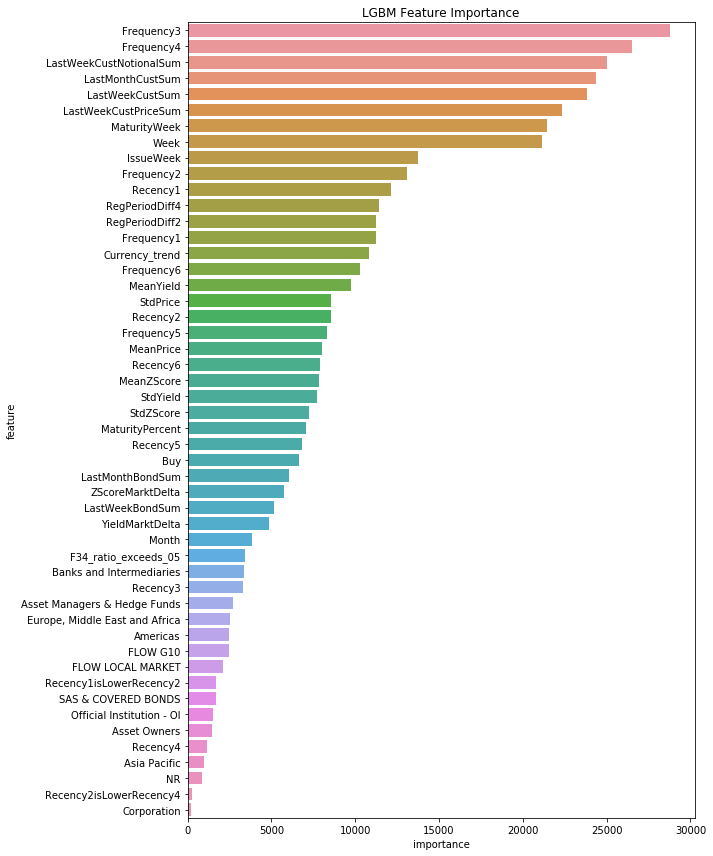

In [202]:
##### VARIABLE IMPORTANCE

# load variable importance
importance = pd.DataFrame()
importance["feature"] = features
importance["importance"] = gbm.feature_importances_

# plot variable importance
plt.figure(figsize = (10, 12))
sns.barplot(x = "importance", y = "feature", data = importance.sort_values(by = "importance", ascending = False))
plt.title('LGBM Feature Importance')
plt.tight_layout()

# save plot as pdf
plt.savefig("../var_importance.pdf")

In [203]:
##### PREDICTION

### VALID DATA

# predict validation set
pred_valid = X_valid[["CustomerIdx", "IsinIdx", "BuySell", "Week", "CustomerInterest"]]
pred_valid["TARGET"] = gbm.predict_proba(X_valid[features], num_iteration = num_iters)[:, 1]
auc = roc_auc_score(y_valid, pred_valid.TARGET)

# check rank correlation with the best submission
best = pd.read_csv("../pred_valid/auc850085_data_v4_0_60_under_wlp_lm_bm_lgb.csv")
best.columns = ['CustomerIdx', 'IsinIdx', 'BuySell', 'Week', 'CustomerInterest', 'TARGET_best']
best = best.merge(pred_valid[["CustomerIdx", "IsinIdx", "BuySell", "TARGET"]], 
                  how = "right", on = ["CustomerIdx", "IsinIdx", "BuySell"])
print(spearmanr(best.TARGET, best.TARGET_best))

# export CSV
pred_valid.to_csv("../pred_valid/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb.csv", 
                  index = False, float_format = "%.8f")


### TEST DATA

# predict test set
test["TARGET"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

# check rank correlation with the best submission
best = pd.read_csv("../submissions/auc850085_data_v4_0_60_under_wlp_lm_bm_lgb_2stage.csv")
best = best.merge(test[["PredictionIdx", "TARGET"]], how = "left", on = "PredictionIdx")
print(spearmanr(best["TARGET"], best.CustomerInterest))

# export CSV
subm = best[["PredictionIdx", "TARGET"]]
subm.columns = ["PredictionIdx", "CustomerInterest"]
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb_1stage.csv", 
            index = False, float_format = "%.8f")

SpearmanrResult(correlation=0.9971308812298834, pvalue=0.0)
SpearmanrResult(correlation=0.9878820748738804, pvalue=0.0)


# 5. MODELING - STAGE 2

In [204]:
# keep top features
#top = 100
#features = list(importance["feature"][0:np.min([top, len(features)])])

In [205]:
# use full data as train
X_train = data.loc[data.Week <= 120]
y_train = data.loc[data.Week <= 120].CustomerInterest

In [206]:
### retrain model with the best iters

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = num_iters,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = 42,
                         num_threads      = cores)

# train lightGBM
gbm = gbm.fit(X_train[features], y_train, 
              eval_set = [(X_train[features], y_train)], 
              eval_metric = metric, verbose = 250)

[250]	valid_0's auc: 0.836558
[500]	valid_0's auc: 0.839655
[750]	valid_0's auc: 0.842417
[1000]	valid_0's auc: 0.84452
[1250]	valid_0's auc: 0.846265
[1500]	valid_0's auc: 0.847939
[1750]	valid_0's auc: 0.849483
[2000]	valid_0's auc: 0.850865
[2250]	valid_0's auc: 0.85208
[2500]	valid_0's auc: 0.853232
[2750]	valid_0's auc: 0.854256
[3000]	valid_0's auc: 0.855195
[3250]	valid_0's auc: 0.856066
[3500]	valid_0's auc: 0.856924
[3750]	valid_0's auc: 0.857709
[4000]	valid_0's auc: 0.858466
[4250]	valid_0's auc: 0.859198
[4500]	valid_0's auc: 0.859928
[4750]	valid_0's auc: 0.860585
[5000]	valid_0's auc: 0.861235
[5250]	valid_0's auc: 0.861849
[5500]	valid_0's auc: 0.862432
[5750]	valid_0's auc: 0.86301
[6000]	valid_0's auc: 0.863578
[6250]	valid_0's auc: 0.864137


In [207]:
# predict test set
test["TARGET"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

In [208]:
# check rank correlation with the best submission
best = pd.read_csv("../submissions/auc850085_data_v4_0_60_under_wlp_lm_bm_lgb_2stage.csv")
best = best.merge(test[["PredictionIdx", "TARGET"]], how = "left", on = "PredictionIdx")
spearmanr(best["TARGET"], best.CustomerInterest)

SpearmanrResult(correlation=0.9887059505319885, pvalue=0.0)

In [209]:
# export CSV
subm = best[["PredictionIdx", "TARGET"]]
subm.columns = ["PredictionIdx", "CustomerInterest"]
subm.to_csv("../submissions/auc" + str(round(auc, 6))[2:8] + "_" + str(data_name) + "_lgb_2stage.csv", 
            index = False, float_format = "%.8f")